# 06 — Comparativa Final de Modelos (CV)

**Objetivo:** Presentar una comparación clara y directa del rendimiento de cada modelo optimizado (HGB, XGB, LGBM) y del modelo de Stacking, utilizando las métricas finales de validación cruzada.

**Entradas:**
- **API de MLflow:** Se conecta al servidor de tracking (DagsHub) para recuperar las métricas de los `runs` correspondientes al `stage` `train`.

**Salidas:**
- **Tabla Comparativa:** Un DataFrame ordenado que muestra el score final `rmsle_cv` para cada modelo.
- **Gráfico de Barras:** Una visualización que permite comparar rápidamente el rendimiento de los modelos.

**Dependencias:**
- Requiere haber ejecutado el pipeline de DVC completo, incluyendo el `stage` `train` (`dvc repro train`).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.logging_utils import setup_logger

logger = setup_logger("model_baselines_cv")
sns.set(style="whitegrid", palette="viridis")
logger.info("Notebook 06_model_baselines_cv iniciado.")

2025-08-24 16:05:42.474 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops


2025-08-24 16:05:42.484 | INFO     | __main__:<module>:17 - Notebook 06_model_baselines_cv iniciado.
2025-08-24 16:05:42 | INFO | Notebook 06_model_baselines_cv iniciado.


In [2]:
import os
os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/fertueros/insurance-mlops.mlflow"

client = mlflow.tracking.MlflowClient()
print(f"Conectado a MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print("Experimentos encontrados:")
for exp in client.search_experiments():
    print(f"  - Nombre: {exp.name}, ID: {exp.experiment_id}")

Conectado a MLflow Tracking URI: https://dagshub.com/fertueros/insurance-mlops.mlflow
Experimentos encontrados:
  - Nombre: hyperparameter-tuning, ID: 3
  - Nombre: ml-pipeline, ID: 2
  - Nombre: eda-baseline, ID: 0


In [3]:
EXPERIMENT_ID = "2"

In [4]:
try:
    runs_df = mlflow.search_runs(experiment_ids=[EXPERIMENT_ID], order_by=["start_time DESC"])
    
    # Encontrar el último run padre (el que orquestó la CV final)
    parent_run = runs_df[runs_df["tags.mlflow.runName"] == "train-cv"].iloc[0]
    parent_run_id = parent_run.run_id
    logger.info(f"Run padre encontrado: {parent_run_id}")

    # Filtrar para obtener solo los runs anidados (hijos) de ese padre
    child_runs = runs_df[runs_df["tags.mlflow.parentRunId"] == parent_run_id].copy()
    logger.info(f"Se encontraron {len(child_runs)} runs anidados.")

    # Extraer el nombre del modelo del runName y la métrica
    child_runs["model"] = child_runs["tags.mlflow.runName"].str.replace("-cv", "")
    metrics_df = child_runs[["model", "metrics.rmsle_cv"]].dropna()
    metrics_df = metrics_df.rename(columns={"metrics.rmsle_cv": "rmsle_cv"})

    # Ordenar por el mejor rendimiento
    final_df = metrics_df.sort_values("rmsle_cv")
    
    display(final_df)

except Exception as e:
    logger.error(f"No se pudo cargar el experimento con ID '{EXPERIMENT_ID}': {e}")
    final_df = pd.DataFrame() # Crear un dataframe vacío para que la siguiente celda no falle

2025-08-24 16:05:43.298 | INFO     | __main__:<module>:7 - Run padre encontrado: 6b3677e7fe684ffcb10544115fef13d8
2025-08-24 16:05:43 | INFO | Run padre encontrado: 6b3677e7fe684ffcb10544115fef13d8
2025-08-24 16:05:43.299 | INFO     | __main__:<module>:11 - Se encontraron 3 runs anidados.
2025-08-24 16:05:43 | INFO | Se encontraron 3 runs anidados.


,model,rmsle_cv
0,lgbm,1.131310
2,hgb,1.138243
1,xgb,1.140233


2025-08-24 16:05:43.326 | INFO     | __main__:<module>:2 - Generando gráfico de comparación.
2025-08-24 16:05:43 | INFO | Generando gráfico de comparación.


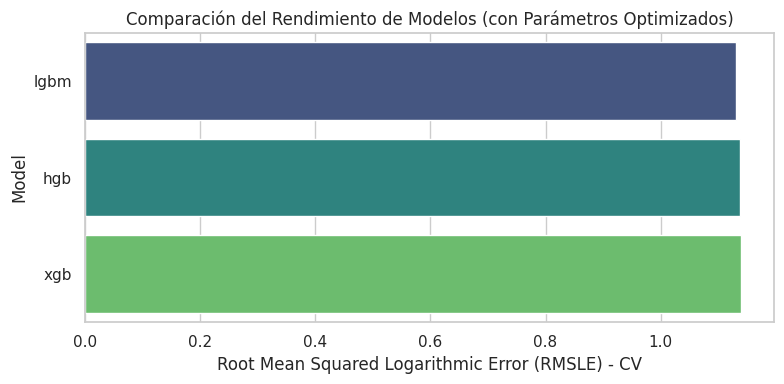

In [5]:
if not final_df.empty:
    logger.info("Generando gráfico de comparación.")
    plt.figure(figsize=(8, 4))
    sns.barplot(
    data=final_df, 
    x="rmsle_cv", 
    y="model", 
    hue="model",       # <-- CORRECCIÓN 1: Asigna 'model' a 'hue'
    palette="viridis", 
    legend=False       # <-- CORRECCIÓN 2: Oculta la leyenda
)
    plt.xlabel("Root Mean Squared Logarithmic Error (RMSLE) - CV")
    plt.ylabel("Model")
    plt.title("Comparación del Rendimiento de Modelos (con Parámetros Optimizados)")
    plt.tight_layout();